In [40]:
import numpy as np, scipy as sp, seaborn as sb

true_a = -3
true_h = 9.25
true_k = 25000
true_sigma = 10

x_data = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12]) 
observed_y = true_a * (x_data - true_h)**2 + true_k + np.random.normal(loc=0, scale=true_sigma, size=len(x_data))

In [46]:
backup_observed_y = observed_y

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

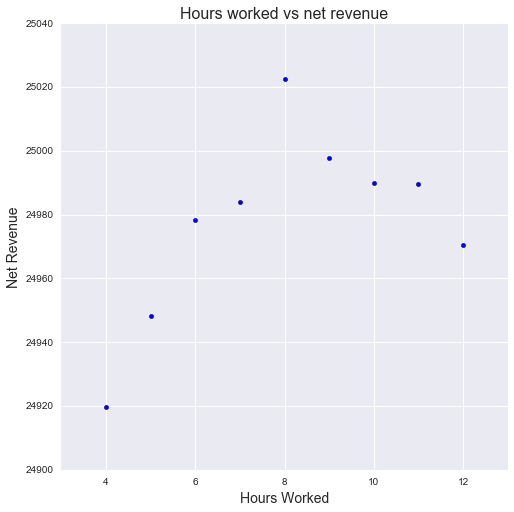

In [42]:
plt.figure(figsize=[8,8])
plt.xlabel('Hours Worked', size=14)
plt.ylabel('Net Revenue', size=14)
#plt.ylim([0,350])
#plt.xlim([0,12])
plt.title('Hours worked vs net revenue', size=16)
plt.scatter(x_data, observed_y);

$ y = a(x-h)^2 + k $


In [26]:
def normalize(log_p):
  shifted_p = np.exp(log_p - np.max(log_p))
  normalized_log_p = shifted_p/shifted_p.sum()
  return normalized_log_p

In [43]:
import itertools
import scipy.stats as ss

# Come up with a hypothesis for each parameter
a_hypotheses = np.array([-4,-3,-2,-1])
h_hypotheses = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
k_hypotheses = np.array([18000, 20000, 23000, 25000, 26000, 28000, 30000])
sigma_hypotheses = np.array([5, 10, 15, 20, 25])

# Create list of every possible combination of them.
hypotheses = list(itertools.product(a_hypotheses, h_hypotheses, k_hypotheses, sigma_hypotheses))

In [44]:
# Start with an uninformative prior
# Every hypothesis gets an equal footing
# We'll be working in log space as an optimization
# So that our numbers don't get so small that the computer 
# rounds them to zero.
hypothesis_likelihoods = np.log(np.array([1]*len(hypotheses)))

for i, hypotheses_tuple in enumerate(hypotheses):
  a_hypothesis, h_hypothesis, k_hypothesis, sigma_hypothesis = hypotheses_tuple
  for x_datum, y_datum in zip(x_data, observed_y):
    # For the given hypothetical value of each parameter
    # let's compute a prediction and the error
    predicted_y = a_hypothesis * (x_datum - h_hypothesis)**2 + k_hypothesis
    prediction_error = y_datum - predicted_y
    
    # On average, the error should be centered around zero
    # just like in a standard regression (aka normal residuals).
    y_probability = ss.norm.pdf(0, loc=prediction_error, scale=sigma_hypothesis)
    
    # Multiply probability density but
    # we're in log space so just add them
    hypothesis_likelihoods[i] += np.log(y_probability)
    
hypothesis_likelihoods = normalize(hypothesis_likelihoods)

#normalized_likelihoods = normalize(hypothesis_likelihoods)
evaluated_hypotheses = list(zip(hypotheses, hypothesis_likelihoods))

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


In [47]:
evaluated_hypotheses

[((-4, 0, 18000, 5), 0.0),
 ((-4, 0, 18000, 10), 0.0),
 ((-4, 0, 18000, 15), 0.0),
 ((-4, 0, 18000, 20), 0.0),
 ((-4, 0, 18000, 25), 0.0),
 ((-4, 0, 20000, 5), 0.0),
 ((-4, 0, 20000, 10), 0.0),
 ((-4, 0, 20000, 15), 0.0),
 ((-4, 0, 20000, 20), 0.0),
 ((-4, 0, 20000, 25), 0.0),
 ((-4, 0, 23000, 5), 0.0),
 ((-4, 0, 23000, 10), 0.0),
 ((-4, 0, 23000, 15), 0.0),
 ((-4, 0, 23000, 20), 0.0),
 ((-4, 0, 23000, 25), 0.0),
 ((-4, 0, 25000, 5), 0.0),
 ((-4, 0, 25000, 10), 0.0),
 ((-4, 0, 25000, 15), 0.0),
 ((-4, 0, 25000, 20), 0.0),
 ((-4, 0, 25000, 25), 1.264849060802196e-317),
 ((-4, 0, 26000, 5), 0.0),
 ((-4, 0, 26000, 10), 0.0),
 ((-4, 0, 26000, 15), 0.0),
 ((-4, 0, 26000, 20), 0.0),
 ((-4, 0, 26000, 25), 0.0),
 ((-4, 1, 18000, 5), 0.0),
 ((-4, 1, 18000, 10), 0.0),
 ((-4, 1, 18000, 15), 0.0),
 ((-4, 1, 18000, 20), 0.0),
 ((-4, 1, 18000, 25), 0.0),
 ((-4, 1, 20000, 5), 0.0),
 ((-4, 1, 20000, 10), 0.0),
 ((-4, 1, 20000, 15), 0.0),
 ((-4, 1, 20000, 20), 0.0),
 ((-4, 1, 20000, 25), 0.0),
 ((-4, 1

In [45]:
max(evaluated_hypotheses, key=lambda x: x[-1])

((-3, 9, 25000, 10), 0.67543446120472606)

In [58]:
import pymc3 as pm

with pm.Model() as model:
    _a = pm.Uniform('a', lower=-10, upper=0)
    _h = pm.Uniform('h', lower=4, upper=12)
    _k = pm.Uniform('k', lower=18000, upper=30000)
    _sigma = pm.Uniform('sigma', lower=5, upper=25)

    predicted_y = _a * (x_data - _h)**2 + _k
    prediction_error = observed_y - predicted_y
    
    y_probability = pm.Normal('y_probability', mu=0, observed=prediction_error, sd=_sigma)
    
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(25000, step, start=start)

100%|██████████| 25000/25000 [00:37<00:00, 665.95it/s]


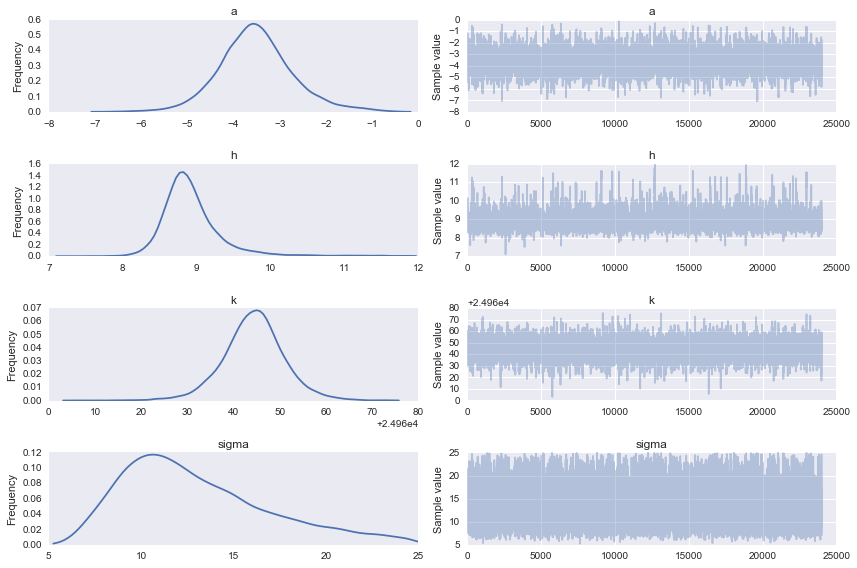

In [59]:
pm.traceplot(trace[1000:]);

In [68]:
mle = {}

for var_name in ['a','h','k','sigma']:
    var_mass, var_bins = np.histogram(trace[var_name], bins=np.arange(-50000,50000, 0.1), density=True)
    var_averaged_bins = 0.5*(var_bins[1:] + var_bins[:-1])
    bin_index = np.argmax(var_mass)
    mle[var_name] = var_averaged_bins[bin_index]

print(mle);

{'h': 8.8499992722754541, 'k': 25003.849998908547, 'a': -3.6500007275426469, 'sigma': 11.149999272241985}
